In [2]:
import numpy as np
import pandas as pd
import helper_pkg
import matplotlib.pyplot as plt
import cmocean
import os, sys
import json, re
import vis_pkg
import time
import cartopy as cartopy
import cartopy.crs as ccrs

from pathlib import Path

In [3]:
# create dictionary of config here
system = sys.platform
if system == "win32":
    conf_dir = Path("D:\\Mac_Documents\\Documents\codes\\region-paths")
else: # assumed to be for unix-based
    conf_dir = Path("/Users/jgra0019/Documents/codes/region-paths")
    
area_list = ['sum', 'sam', 'kur', 'alu', 'ryu', 'cam', 'izu', 'ker']
label_list = ['Southeast Asia',
              'South America',
              'Japan-Kuriles-Kamchatka',
              'Alaska-Aleutians',
              'Ryukyu-Nankai',
              'Central America',
              'Izu-Bonin-Mariana',
              'Tonga-Kermadec'
             ]
area_list = ["ryu"]
label_list = ['Ryukyu-Nankai']

# no need to separate the data in SHF - make sure that only the columns we want are passed to sample_on_grid
path_to_feat_dict = {
    # "crv_d_xyz": ["CRD"],   # no header
    # "crv_s_xyz": ["CRS"],   # no header
    #"crv_ave_xyz": ["CRM"],   # no header
    "bgrv_small_xyz": ["BGR"], # no header
    "fgrv_small_xyz": ["FRE"], # no header
    "sec_inv": ["INV"],         # no header
    "dilat": ["DLT"]           # no header
}

make_map = True
mode = 1 # mode 0 - grids along strike and dip; mode 1 - grids along strike only
 
outdir = "/Users/jgra0019/Documents/codes/ml_proj1/out/data-maps"   # put everything here! Feeling lazy
outdir = Path(outdir)

conf_dict = {}
label_dict = {}

for area, lab in zip(area_list, label_list):
    
    conf_fname = conf_dir/(area + '_conf.json')
    print(conf_fname)
    with open(conf_fname) as json_data_file:
        conf_dict[area] = json.load(json_data_file)
    
    label_dict[area] = lab


/Users/jgra0019/Documents/codes/region-paths/ryu_conf.json


# Functions used in processing mapping
Should I put this into a package? Or no? 

In [4]:
def cmap_lut(val):
    '''
    Look-up table for getting the cmap associated with a ML feature
    '''
    if any(re.findall(r'DEP', val, re.IGNORECASE)):
        cmap = cmocean.cm.rain 
    if any(re.findall(r'THK', val, re.IGNORECASE)):
        cmap = plt.cm.viridis_r
    elif any(re.findall(r'STR', val, re.IGNORECASE)):
        cmap = plt.cm.plasma_r
    elif any(re.findall(r'DIP', val, re.IGNORECASE)):
        cmap = plt.cm.inferno_r
    elif any(re.findall(r'CRD', val, re.IGNORECASE)):
        cmap = plt.cm.magma_r
    elif any(re.findall(r'CRM', val, re.IGNORECASE)):
        cmap = plt.cm.cividis_r
    elif any(re.findall(r'BGR', val, re.IGNORECASE)):
        cmap = cmocean.cm.deep
    elif any(re.findall(r'FRE', val, re.IGNORECASE)):
        cmap = cmocean.cm.dense
    elif any(re.findall(r'INV', val, re.IGNORECASE)):
        cmap = cmocean.cm.algae
    elif any(re.findall(r'DLT', val, re.IGNORECASE)):
        cmap = cmocean.cm.matter
    elif any(re.findall(r'SED_DER', val, re.IGNORECASE)): # test first as it won't accidentally fire SED
        cmap = cmocean.cm.turbid
    elif any(re.findall(r'SED', val, re.IGNORECASE)):
        cmap = cmocean.cm.speed
    elif any(re.findall(r'AREA_DER', val, re.IGNORECASE)):
        cmap = cmocean.cm.amp
    elif any(re.findall(r'AREA', val, re.IGNORECASE)): 
        cmap = cmocean.cm.tempo 
    elif any(re.findall(r'EQ', val, re.IGNORECASE)): # earthquake magnitude
        cmap = cmocean.cm.thermal_r 
    # clip the colormaps to remove the too light or too dark colors
    cmap = cmocean.tools.crop_by_percent(cmap, 20, which='both', N=None)
    return cmap

def for_minmax(val, add_one = True):
    '''
    For creating minimum and maximum values
    '''
    if val < 0: sign = -1
    else: sign = 1

    expo = np.floor(np.log10(np.abs(val)))
    if expo > 0:
        mult = 1/10**(expo)
    else:
        mult = 1
    digit = round(abs(val)*mult)
    #print(digit + 1)
    if add_one:
        new_digit = digit + 1
    else:
        new_digit = digit
    #print(sign*new_digit*10**expo)
    return sign*new_digit*10**expo

def add_sampling_grid(ax, lon_grid, lat_grid, color = 'k', linewidth = 0.1, markersize = 0.01, zorder = 1):
    '''
    Function for adding the sampling grid into a map
    Inputs:
    ax - map axes object
    lon_grid - longitude grid
    lat_grid - latitude grid
    color - color of the grid lines
    linewidth - width of the grid lines
    markersize - markersize - might not be needed
    zorder - layer order of the grid lines
    Returns:
    None
    '''
    
    for i in np.arange(lon_grid.shape[0]):
        lon_to_plot = lon_grid[i, :]
        lat_to_plot = lat_grid[i, :]
        ax.plot(lon_to_plot, lat_to_plot, '-', transform = cartopy.crs.PlateCarree(), color = color, 
                linewidth = linewidth, markersize = markersize, zorder = zorder)

    # plot along col of pos array
    for i in np.arange(lat_grid.shape[1]):
        lon_to_plot = lon_grid[:, i]
        lat_to_plot = lat_grid[:, i]
        ax.plot(lon_to_plot, lat_to_plot, '-', transform = cartopy.crs.PlateCarree(), color = color, 
                linewidth = linewidth, markersize = markersize, zorder = zorder)
        
    return

## Open map settings

In [5]:
map_set_fname = "/Users/jgra0019/Documents/codes/globdat-paths/map_setting_conf.json"
with open(map_set_fname) as data_file:
    print(map_set_fname)
    all_map_setting = json.load(data_file)

all_map_setting["ryu"]

/Users/jgra0019/Documents/codes/globdat-paths/map_setting_conf.json


{'trench_arr_sz': 5,
 'pr1_scatter_sz': 0.7,
 'eq_as_line': 1,
 'label_rel_pos': 0.1,
 'contour_fnt_sz': 6,
 'contour_lwidth': 0.4,
 'tomo_mrkr_sz': 33,
 'tomo_lab_x': 0.005,
 'tomo_lab_y': 0.02,
 'region_lab_x': 0.01,
 'region_lab_y': 0.95}

# Sampling process

In [6]:
# run for all regions
debug = True # better if this is always set as True
region = 'ryu'
for key in conf_dict.keys():
    print(key)
    
    if debug:
        if key != region: # debugging 
            continue

    # read regional configuration file
    map_setting = all_map_setting[key]
    
    conf = conf_dict[key]

    if system == "win32":
        root_dir = Path(conf["win_root"]) 
    else:
        root_dir = Path(conf["mac_root"])
    other_set = conf["conf"]
    ml_conf = conf["xai"]
    conf = conf["path"]
    
    '''
    # Some region-dependent settings
    '''
    # convert range of longitude to -180 to 180 if alu - convert range as there are some crossings of the 180 lon
    is_alu = False
    is_ker = False
    if any(re.findall(r'alu', key, re.IGNORECASE)):
        is_alu = True
    if any(re.findall(r'ker', key, re.IGNORECASE)):
        is_ker = True
        
    eq_fname = conf["com_nets"]
    #eq_fname = root_dir/conf["isc_mth2"]
    dep_fname = root_dir/conf["dep_xyz_100"]

    '''
    # Read earthquake data
    '''
    eq_df = pd.read_csv(eq_fname, header = None)
    eq_df.columns = ['LON', 'LAT', 'DEPTH', 'DATE', 'TIME', 'EVENT_ID', 'DEPFIX', 'DEPQUAL', 'EX', 'MO',
           'MW', 'EX.1', 'MRR', 'MTT', 'MPP', 'MRT', 'MTP', 'MPR', 'STRIKE', 'DIP',
           'RAKE', 'STRIKE.1', 'DIP.1', 'RAKE.1', 'EX.2', 'T_VAL', 'T_PL', 'T_AZM',
           'P_VAL', 'P_PL', 'P_AZM', 'N_VAL', 'N_PL', 'N_AZM', 'SLAB_DIP', 'CLASS']
    eq_df["LON"] = eq_df["LON"]%360
    
    

    eq_df = eq_df[eq_df['CLASS'] == 'MTHRUST']
    eq_df = eq_df[['LON', 'LAT', 'DEPTH', 'DATE', 'TIME', 'MW']]

    # open file containing earthquakes before catalogue if there is one
    try: 
        old_df = pd.read_csv(root_dir/conf["rup_len_est2"], sep =',', comment = '#', header = 'infer')
        old_df = old_df[["LON", "LAT", "DEPTH", "DATE", "TIME", "MW"]]
        old_df["LON"] = old_df["LON"]%360
        
    except:
        old_df = None
    
    if old_df is None:
        None
    else:
        eq_df = pd.concat([eq_df , old_df], axis = 0)
    
    eq_df = eq_df.reset_index(drop=True)
    eq_df = eq_df.sort_values(by = 'MW', ascending = False)

    dep_df = pd.read_csv(dep_fname, header = 'infer')
    dep_df.columns = ['LON', 'LAT', 'VAL']
    dep_df["LON"] = dep_df["LON"]%360

    # if lon_rng_180:
    #     idx = dep_df[dep_df['LON'] > 180].index
    #     dep_df['LON'].loc[idx] -= 360 

    # lon_min = dep_df['LON'].min() #
    # lon_max = dep_df['LON'].max()
    # lat_min = dep_df['LAT'].min()
    # lat_max = dep_df['LAT'].max()

    dep_df['VAL'] = -dep_df['VAL']
    dep_df = dep_df[dep_df['VAL'] <= 70]
    
    '''
    # Read features we want to use and take samples of
    '''
    # data processed first

    feat_dict = {}

    for i in path_to_feat_dict.keys():
        feat = path_to_feat_dict[i] # feature name
        path = root_dir/conf[i] # key is the key to conf also

        # debug
        #print(path)
        #print(feat)
        # can put this outside the for loop
        head_list = ["SED_OG", "SED_DER_OG", "AREA", "AREA_DER"] # should correspond to the column names in the data file
        noh_com_list = ["THK", "STR", "DIP"]

        if any([f in head_list for f in feat]):
            feat_df = pd.read_csv(path, header = "infer", sep = ",") # current 
            feat_df = feat_df[["LON_AVE", "LAT_AVE"] + feat]

        else: # data with no header
            if any([f in noh_com_list for f in feat]):
                sep = ","
            else:
                sep = "\t"
            feat_df = pd.read_csv(path, header = None, sep = sep)
            #print(feat_df.columns)

        # common to both cases
        feat_df = feat_df.dropna()
        feat_df = feat_df.reset_index(drop=True)
        feat_df.columns = ["LON", "LAT"] + feat # just replace lon_ave, lat_ave with lon, lat

        # convert lon of feat_df if it's -180 to 180
        feat_df["LON"] = feat_df["LON"]%360

        # if lon_rng_180:
        #     idx = feat_df[feat_df['LON'] > 180].index
        #     feat_df['LON'].loc[idx] -= 360 

        #print("Saving ...")
        for f in feat:
            new_feat = f.replace("_OG","") # remove OG - or any other unused suffix if present
            to_save = feat_df[["LON", "LAT", f]]
            to_save.columns = ["LON", "LAT", "VAL"]  
            feat_dict[new_feat] = to_save
            #print(feat_dict[new_feat].columns)

        #print('Longitude range: ', feat_df['LON'].min(),"\t", feat_df['LON'].max())
        #print('Latitude range: ', feat_df['LAT'].min(),"\t", feat_df['LAT'].max())
    
    '''
    # Proceed in here - sample the data
    '''
    if mode == 0: 
        n_max = 140 # in km in direction of downgoing plate
        n_min = -600 # in km in direction of upper plate
        dn = 20 # step in the n-axis
        ds = 20 # step in the s-axis 
    elif mode == 1:
        n_max = 300 # in km in direction of downgoing plate # originally 500 km
        n_min = -300 # in km in direction of upper plate
        dn = 300 # step in the n-axis
        ds = 50 # step in the s-axis 

    n_ax, s_ax, lon_grid, lat_grid = helper_pkg.make_grid(root_dir/conf["grid_dir_20"], n_max = n_max, n_min = n_min, dn = dn, ds = ds, ncdf_fname = None)
    # convert lon_grid to 0 to 360
    lon_grid = lon_grid%360
    
    '''
    # Prepare container of data
    '''
    feat_list = [x for x in feat_dict.keys()]
    eq_df_col = eq_df.columns
    #print(feat_list)
    
    '''
    # Code for getting largest earthquake in every grid element
    # We also sample grids with no earthquake, but with available data (< 70 km depth)
    '''
    st = time.time()
    print("Executing sampling: ")

    grid_feat_dict = helper_pkg.sample_on_grid(s_ax, n_ax, lon_grid, lat_grid, dep_df, feat_dict, eq_df.columns, eq_df, mode = mode, debug = False)

    ed = time.time()

    print('Processing done after: ', (ed - st)/60)
    
    '''
    # Just some debugging options - check the area of the sampled data
    '''
    # print('Longitude range: ', grid_feat_dict['LON'].min(),"\t", grid_feat_dict['LON'].max())
    # print('Latitude range: ', grid_feat_dict['LAT_AVE'].min(),"\t", grid_feat_dict['LAT_AVE'].max())

    trench_plt = pd.read_csv(root_dir/conf["trench_full"], sep=',', header = None) 
    trench_plt.columns = ['LON', 'LAT']
    

ryu
Executing sampling: 
Processing done after:  4.125502181053162


In [7]:
grid_feat_dict.keys()

Index(['LON', 'LAT', 'DEPTH', 'DATE', 'TIME', 'MW', 'DEP_AVE', 'LON_AVE',
       'LAT_AVE', 'S_AVE', 'N_AVE', 'BGR_AVE', 'BGR_STD', 'BGR_MAX', 'BGR_MIN',
       'BGR_P05', 'BGR_P25', 'BGR_P50', 'BGR_P75', 'BGR_P95', 'BGR_SKW',
       'BGR_KUR', 'FRE_AVE', 'FRE_STD', 'FRE_MAX', 'FRE_MIN', 'FRE_P05',
       'FRE_P25', 'FRE_P50', 'FRE_P75', 'FRE_P95', 'FRE_SKW', 'FRE_KUR',
       'INV_AVE', 'INV_STD', 'INV_MAX', 'INV_MIN', 'INV_P05', 'INV_P25',
       'INV_P50', 'INV_P75', 'INV_P95', 'INV_SKW', 'INV_KUR', 'DLT_AVE',
       'DLT_STD', 'DLT_MAX', 'DLT_MIN', 'DLT_P05', 'DLT_P25', 'DLT_P50',
       'DLT_P75', 'DLT_P95', 'DLT_SKW', 'DLT_KUR'],
      dtype='object')

# Create sampled maps and save them 

In [8]:
outpath = outdir/region
suffix = '_sampled.png'
dpi = 600

cols = grid_feat_dict.columns
'''
Prepare the map configurations
'''
trench_arr_sz = all_map_setting[region]['trench_arr_sz']
if make_map:
    for col in cols:
        if not any(re.findall(r'AVE', col, re.IGNORECASE)):
            continue
        if col in ['LAT_AVE', 'LON_AVE', 'S_AVE', 'N_AVE', "DEP_AVE"]:
            continue
        # else do the rest
        title = col
        #title = r"2nd invariant $10^{-9}$ $yr^{-1}$"
        
        '''
        Set the colormap accordingly - assume that all are sequential
        Use light to dark colormaps
        Is there an easier way to do this? - put in a function
        '''
        cmap = cmap_lut(col)

        
        # for the colormap ticks
        vmin = np.nanquantile(grid_feat_dict[col], 0.05)
        vmax = np.nanquantile(grid_feat_dict[col], 0.95)
        vmin_new = for_minmax(vmin)
        vmax_new = for_minmax(vmax)
        
        if vmin_new == vmax_new: # for data with really small range
            vmin_new = vmin_new - 0.1*vmin_new
            vmax_new = vmin_new + 0.1*vmin_new

        print(col)
        print("Original: ", vmin, vmax)
        print("Rounded: ", vmin_new, vmax_new)
        tick_use = vmin_new + np.array([0, 0.5, 1])*(vmax_new - vmin_new)
        #tick_use = np.round(tick_use, 2)
        print(tick_use)

        mapper = vis_pkg.Mapper(dpi = dpi,
                        data = {"LON": grid_feat_dict["LON_AVE"],
                                "LAT": grid_feat_dict["LAT_AVE"],
                                "VAL": grid_feat_dict[col]},
                        topo = None,
                        extent = other_set["map_extent"],
                        dim_inch = other_set["map_wh_inch"],
                        is_alu = is_alu,
                        is_ker = is_ker
                        )
        mapper.create_basemap()
        mapper.add_trench_line(trench_df = trench_plt)
        mapper.add_trench_marker(trench_fname = root_dir/conf["trench_used"],
                                trench_arr_sz = trench_arr_sz
                                )
        mapper.add_data(cmap = cmap, vmin = vmin_new, vmax = vmax_new, mrkr_sz = 2.5)
        mapper.add_cbar_or_title(cbar_pos = [0.7, 0.75, 0.15, 0.05], title = col, tick_size = 7)



        # fig, m = vis_pkg.make_heatmap(to_plot["LON"], to_plot["LAT"], to_plot["VAL"], 
        #                             title, cmap, vmin_new, vmax_new, 2, mrkr_edge=None, mrkr_lw = None, is_alu = is_alu, is_ker = is_ker,
        #                             norm = None, topo = None, extent = other_set["map_extent"], depth = None, 
        #                             trench_df = trench_plt, trench_fname = root_dir/conf["trench_used"], trench_arr_sz = trench_arr_sz,
        #                             eq_outlines_dict = None, label_dict = None, cbar_pos = other_set["cbar_ax"], 
        #                             cbar_ticks = tick_use, cbar_minor_ticks = None, dim_inch = other_set["map_wh_inch"], dpi = 600)

        add_sampling_grid(mapper.ax, lon_grid, lat_grid, color = 'k', linewidth=0.3, markersize=0.01, zorder = 1)


        # save the figure
        imgfile = col.lower() + suffix
        imgfile = outpath/imgfile
        print(imgfile)
        mapper.fig.savefig(imgfile, bbox_inches='tight')
        plt.close()
        
        

make_map = True # FIXME: remove this afterwards

BGR_AVE
Original:  190.98607664865162 473.8146189908021
Rounded:  300.0 600.0
[300. 450. 600.]


/Users/jgra0019/opt/anaconda3/envs/proj2/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/jgra0019/opt/anaconda3/envs/proj2/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/Users/jgra0019/opt/anaconda3/envs/proj2/lib/python3.9/site-packages/scipy/signal/signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


/Users/jgra0019/Documents/codes/ml_proj1/out/data-maps/ryu/bgr_ave_sampled.png
FRE_AVE
Original:  -14.575753971959838 36.54941916749233
Rounded:  -20.0 50.0
[-20.  15.  50.]


/Users/jgra0019/opt/anaconda3/envs/proj2/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/jgra0019/opt/anaconda3/envs/proj2/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/Users/jgra0019/opt/anaconda3/envs/proj2/lib/python3.9/site-packages/scipy/signal/signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


/Users/jgra0019/Documents/codes/ml_proj1/out/data-maps/ryu/fre_ave_sampled.png
INV_AVE
Original:  7.129697006540933 503.6936686849026
Rounded:  8.0 600.0
[  8. 304. 600.]


/Users/jgra0019/opt/anaconda3/envs/proj2/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/jgra0019/opt/anaconda3/envs/proj2/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/Users/jgra0019/opt/anaconda3/envs/proj2/lib/python3.9/site-packages/scipy/signal/signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


/Users/jgra0019/Documents/codes/ml_proj1/out/data-maps/ryu/inv_ave_sampled.png
DLT_AVE
Original:  -342.6124749213777 -6.439013307255003
Rounded:  -400.0 -7.0
[-400.  -203.5   -7. ]
/Users/jgra0019/Documents/codes/ml_proj1/out/data-maps/ryu/dlt_ave_sampled.png


/Users/jgra0019/opt/anaconda3/envs/proj2/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/jgra0019/opt/anaconda3/envs/proj2/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/Users/jgra0019/opt/anaconda3/envs/proj2/lib/python3.9/site-packages/scipy/signal/signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


# Create maps of the original data and save them 

BGR
Original:  122.9110946655 504.6475677495
Rounded:  200.0 600.0
[200. 400. 600.]


/Users/jgra0019/opt/anaconda3/envs/proj2/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/jgra0019/opt/anaconda3/envs/proj2/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/Users/jgra0019/opt/anaconda3/envs/proj2/lib/python3.9/site-packages/scipy/signal/signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


ValueError: keyword labeltosp is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_contains', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

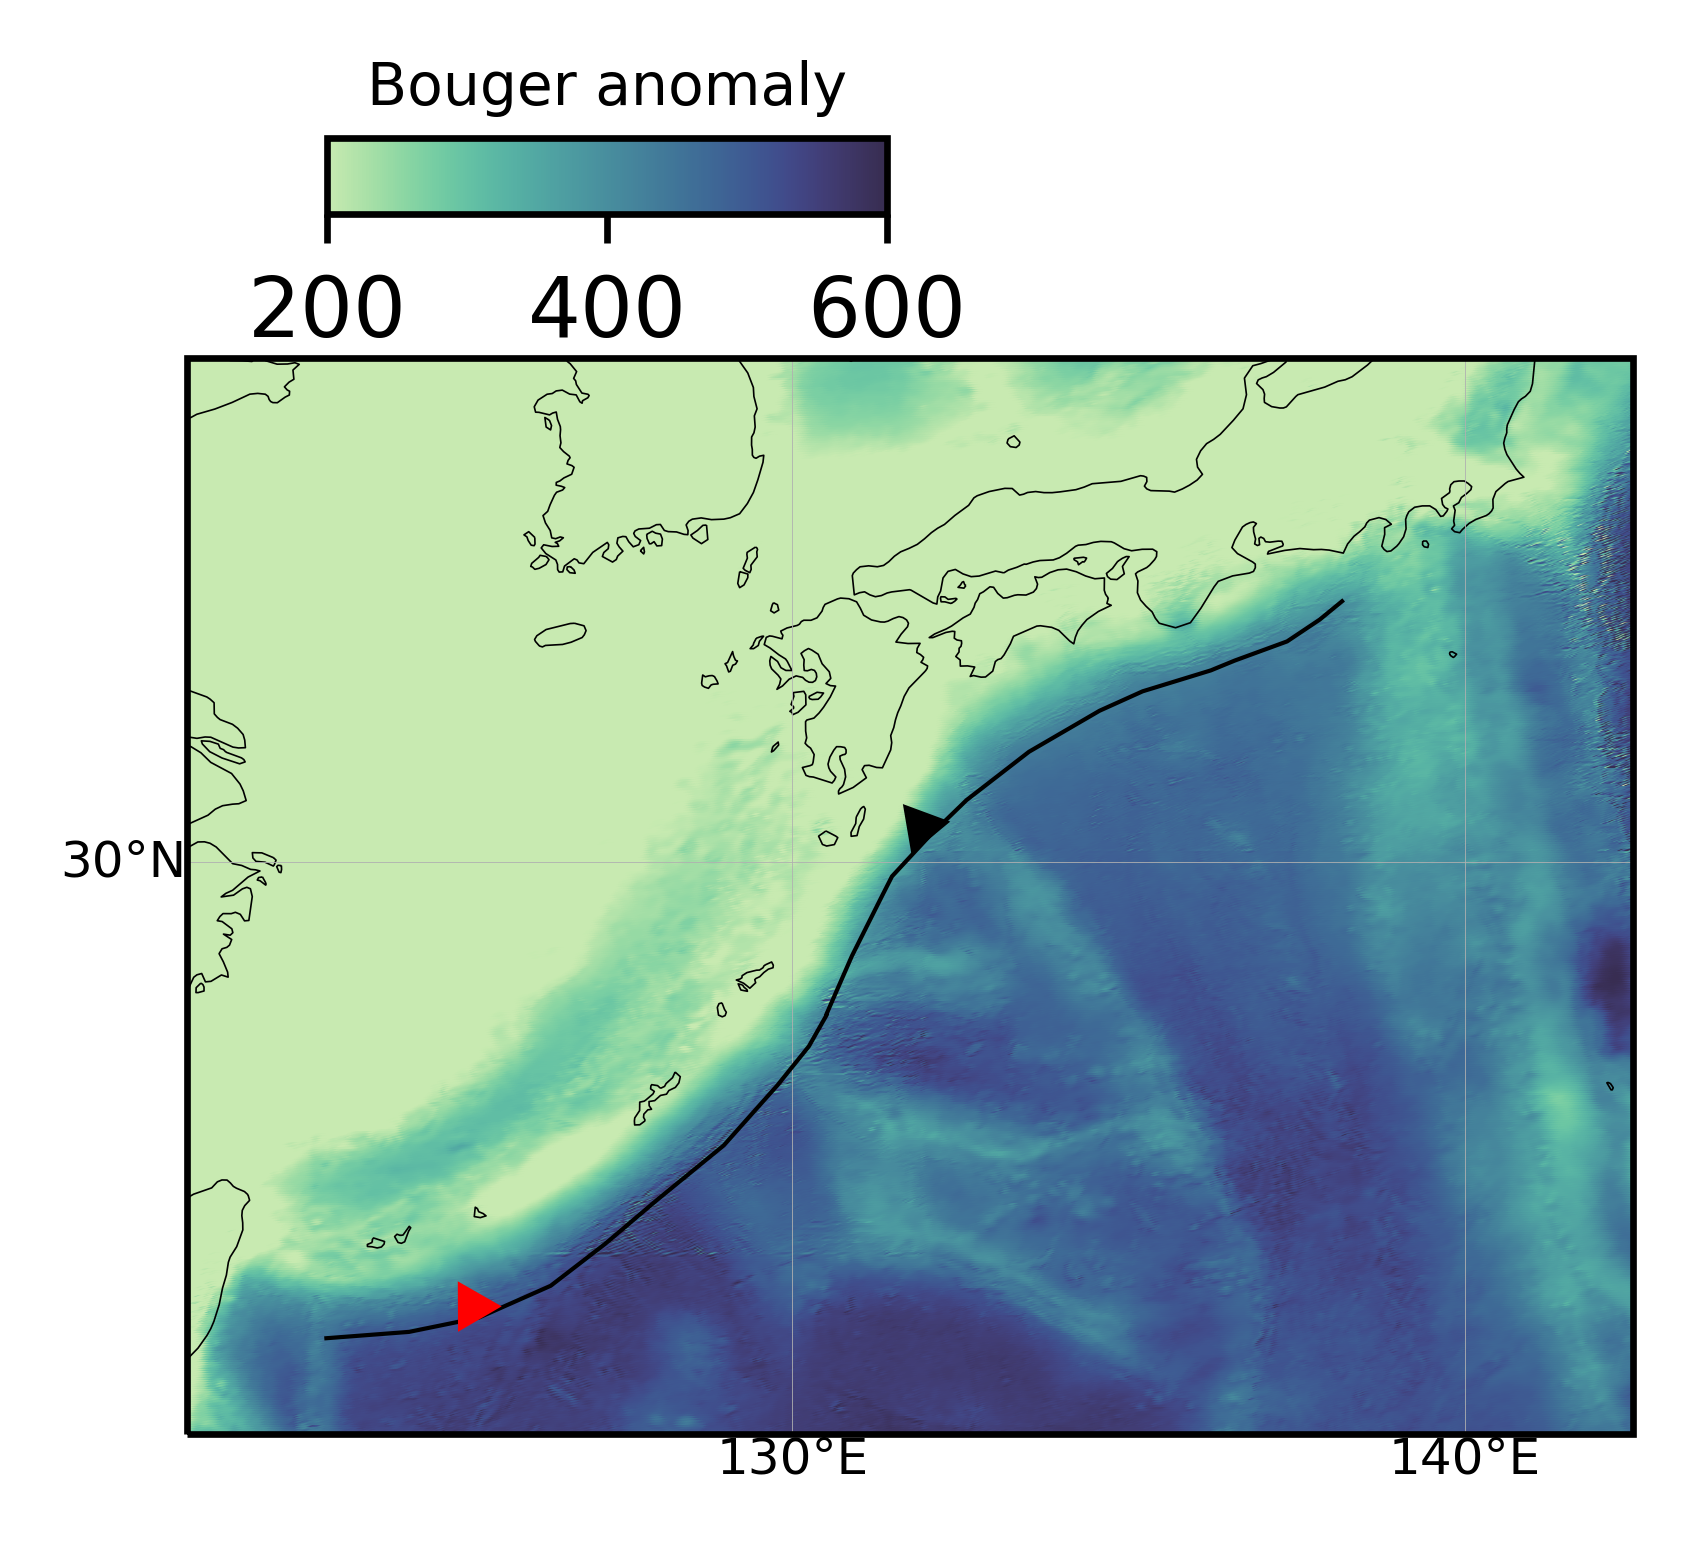

In [10]:
if make_map:
    outpath = outdir/region
    suffix = '_og.png'

    for key in feat_dict.keys():
        
        to_plot = feat_dict[key] # get data to plot
        title = key # set the title
        #title = r"2nd invariant $10^{-9}$ $yr^{-1}$"
        
        '''
        Set the colormap accordingly - assume that all are sequential
        Use light to dark colormaps
        Is there an easier way to do this? - put in a function
        '''
        cmap = cmap_lut(key)

        # for the colormap ticks
        vmin = np.nanquantile(to_plot['VAL'], 0.15)
        vmax = np.nanquantile(to_plot['VAL'], 0.85)
        vmin_new = for_minmax(vmin)
        vmax_new = for_minmax(vmax)
        
        if vmin_new == vmax_new: # for data with really small range
            vmin_new = vmin_new - 0.1*vmin_new
            vmax_new = vmin_new + 0.1*vmin_new

        print(key)
        print("Original: ", vmin, vmax)
        print("Rounded: ", vmin_new, vmax_new)
        tick_use = vmin_new + np.array([0, 0.5, 1])*(vmax_new - vmin_new)
        tick_use = np.round(tick_use, 2)
        print(tick_use)

        mapper = vis_pkg.Mapper(dpi = dpi,
                        data = to_plot,
                        topo = None,
                        extent = other_set["map_extent"],
                        dim_inch = other_set["map_wh_inch"],
                        is_alu = is_alu,
                        is_ker = is_ker
                        )
        mapper.create_basemap()
        mapper.add_trench_line(trench_df = trench_plt)
        mapper.add_trench_marker(trench_fname = root_dir/conf["trench_used"],
                                trench_arr_sz = trench_arr_sz
                                )
        mapper.add_data(cmap = cmap, vmin = vmin_new, vmax = vmax_new, mrkr_sz = 5)
        mapper.add_cbar_or_title(cbar_pos = [0.2, 0.95, 0.3, 0.05], title = "Bouger anomaly", tick_size = None, cbar_ticks = tick_use)

        # fig, m = vis_pkg.make_heatmap(to_plot["LON"], to_plot["LAT"], to_plot["VAL"], 
        #                             title, cmap, vmin_new, vmax_new, 3, is_alu = is_alu, 
        #                             norm = None, topo = None, extent = other_set["map_extent"], depth = None, 
        #                             trench_df = trench_plt, trench_fname = root_dir/conf["trench_used"], trench_arr_sz = trench_arr_sz,
        #                             eq_outlines_dict = None, label_dict = None, cbar_pos = other_set["cbar_ax_in"], 
        #                             cbar_ticks = tick_use, cbar_minor_ticks = None, dim_inch = other_set["map_wh_inch"], dpi = 600)

        add_sampling_grid(mapper.ax, lon_grid, lat_grid, color = 'k', linewidth=0.2, markersize=0.01, zorder = 1)

        
        # save the figure
        imgfile = key.lower() + suffix
        imgfile = outpath/imgfile
        print(imgfile)
        mapper.fig.savefig(imgfile, bbox_inches='tight')
        break
        

# Map of the grid alone in the region

/Users/jgra0019/opt/anaconda3/envs/proj2/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/jgra0019/opt/anaconda3/envs/proj2/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/Users/jgra0019/opt/anaconda3/envs/proj2/lib/python3.9/site-packages/scipy/signal/signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


/Users/jgra0019/Documents/codes/ml_proj1/out/data-maps/ryu/region_grid.png


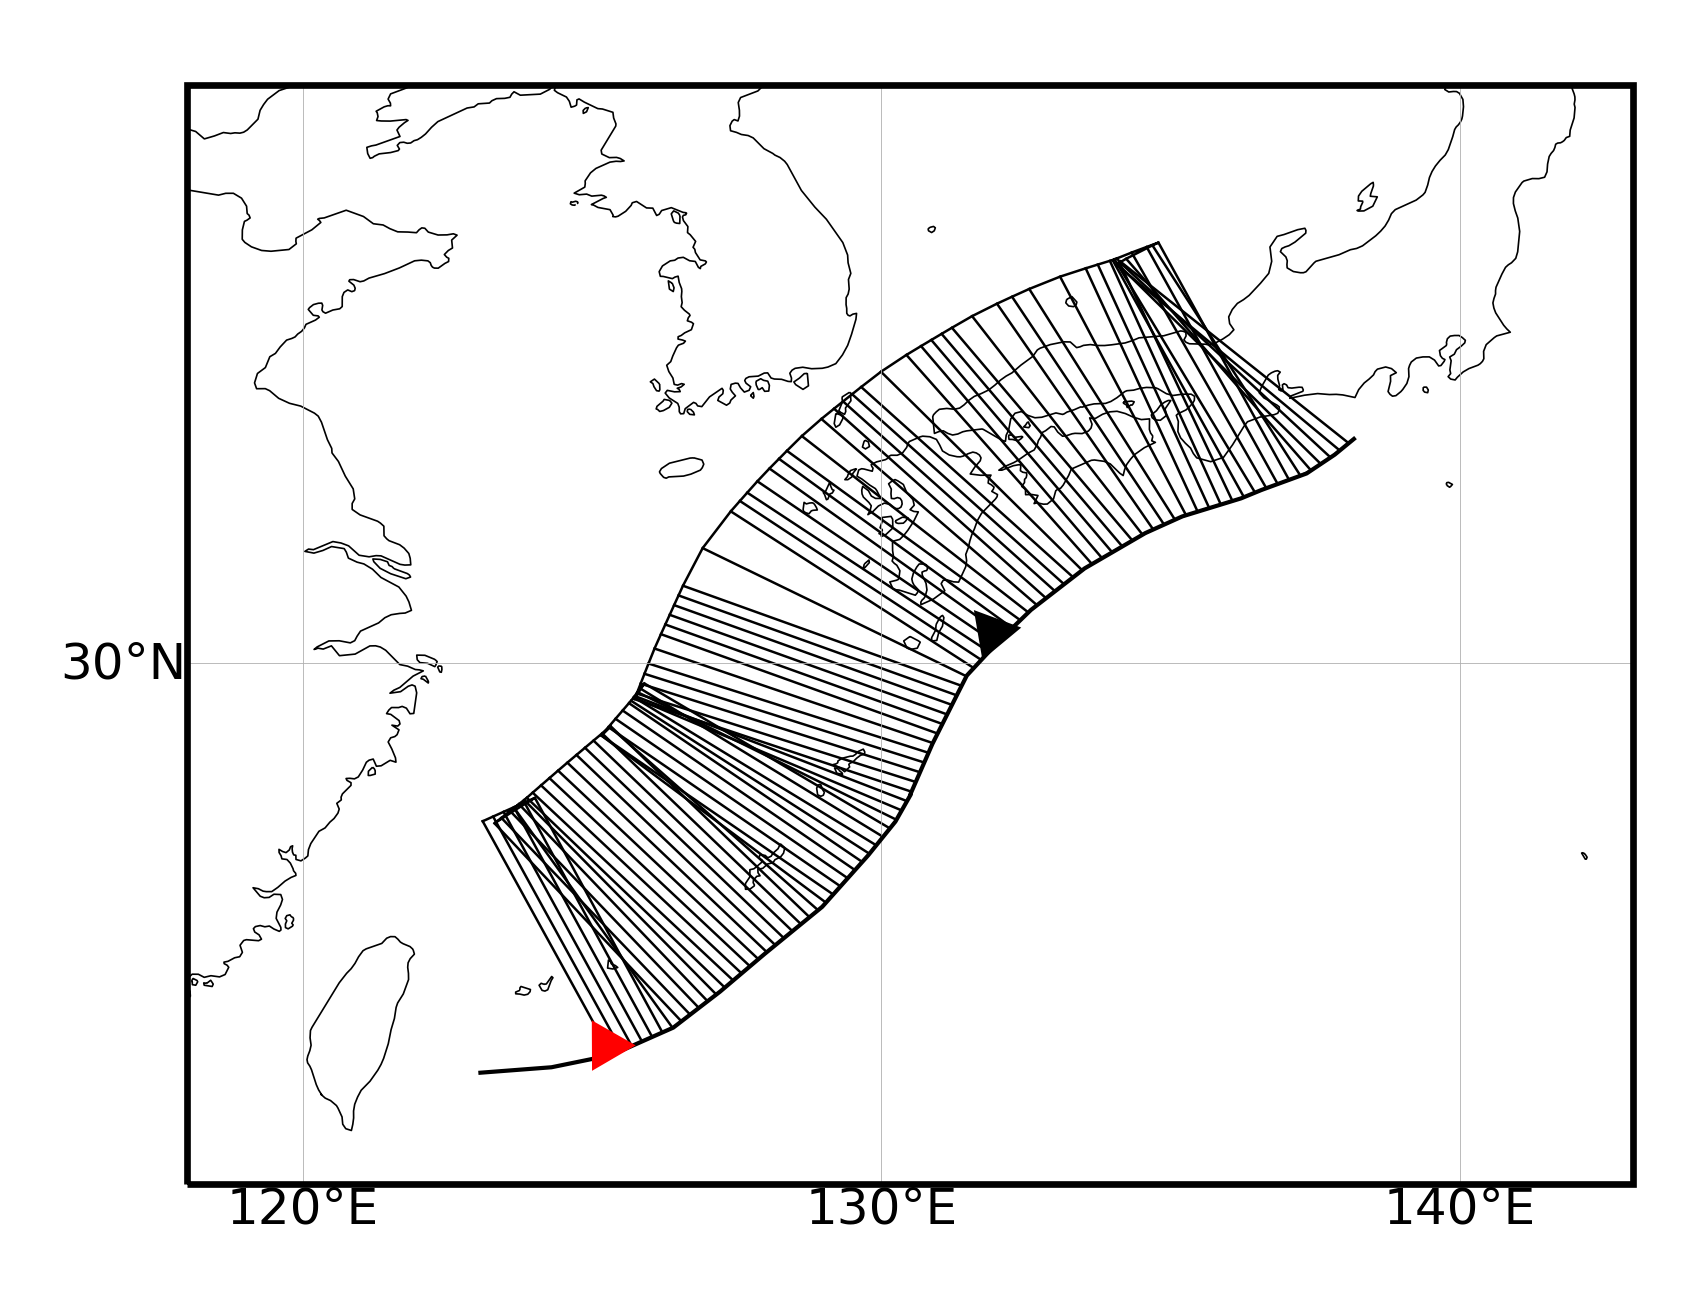

In [ ]:
make_map = True
trench_plt = pd.read_csv(root_dir/conf["trench_full"], sep=',', header = None) 
trench_plt.columns = ['LON', 'LAT']
trench_arr_sz = all_map_setting[region]['trench_arr_sz']

if make_map:
    outpath = outdir/region
    suffix = 'region_grid.png'

    fig, m = vis_pkg.make_heatmap(None, None, None, 
                                None, None, None, None, None, is_alu = is_alu, 
                                norm = None, topo = None, extent = other_set["map_extent"], depth = None, 
                                trench_df = trench_plt, trench_fname = root_dir/conf["trench_used"], trench_arr_sz = trench_arr_sz,
                                eq_outlines_dict = None, label_dict = None, cbar_pos = None, 
                                cbar_ticks = None, cbar_minor_ticks = None, dim_inch = other_set["map_wh_inch"], dpi = 600)

    add_sampling_grid(m, lon_grid, lat_grid, color = 'k', linewidth=0.2, markersize=0.01, zorder = 1)


    # save the figure
    imgfile = outpath/suffix
    print(imgfile)
    fig.savefig(imgfile, bbox_inches='tight')
        

# Map of the raw earthquake data

/Users/jgra0019/Documents/phd_data/slip_models/ryu/slip_outline_csv/1968_HYUGA_outline.csv
/Users/jgra0019/Documents/phd_data/slip_models/ryu/slip_outline_csv/1968_HYUGA_outline.csv
Index(['COUNT', 'LON', 'LAT'], dtype='object')
/Users/jgra0019/Documents/phd_data/slip_models/ryu/slip_outline_csv/1946_NANKAI_outline.csv
/Users/jgra0019/Documents/phd_data/slip_models/ryu/slip_outline_csv/1946_NANKAI_outline.csv
Index(['LON', 'LAT', 'COUNT'], dtype='object')
/Users/jgra0019/Documents/phd_data/slip_models/ryu/slip_outline_csv/1944_NANKAI_outline.csv
/Users/jgra0019/Documents/phd_data/slip_models/ryu/slip_outline_csv/1944_NANKAI_outline.csv
Index(['COUNT', 'LON', 'LAT'], dtype='object')
[1 3 5 7 9]


/Users/jgra0019/opt/anaconda3/envs/proj2/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/jgra0019/opt/anaconda3/envs/proj2/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/Users/jgra0019/opt/anaconda3/envs/proj2/lib/python3.9/site-packages/scipy/signal/signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


/Users/jgra0019/Documents/codes/ml_proj1/out/data-maps/ryu/eq_grid.png


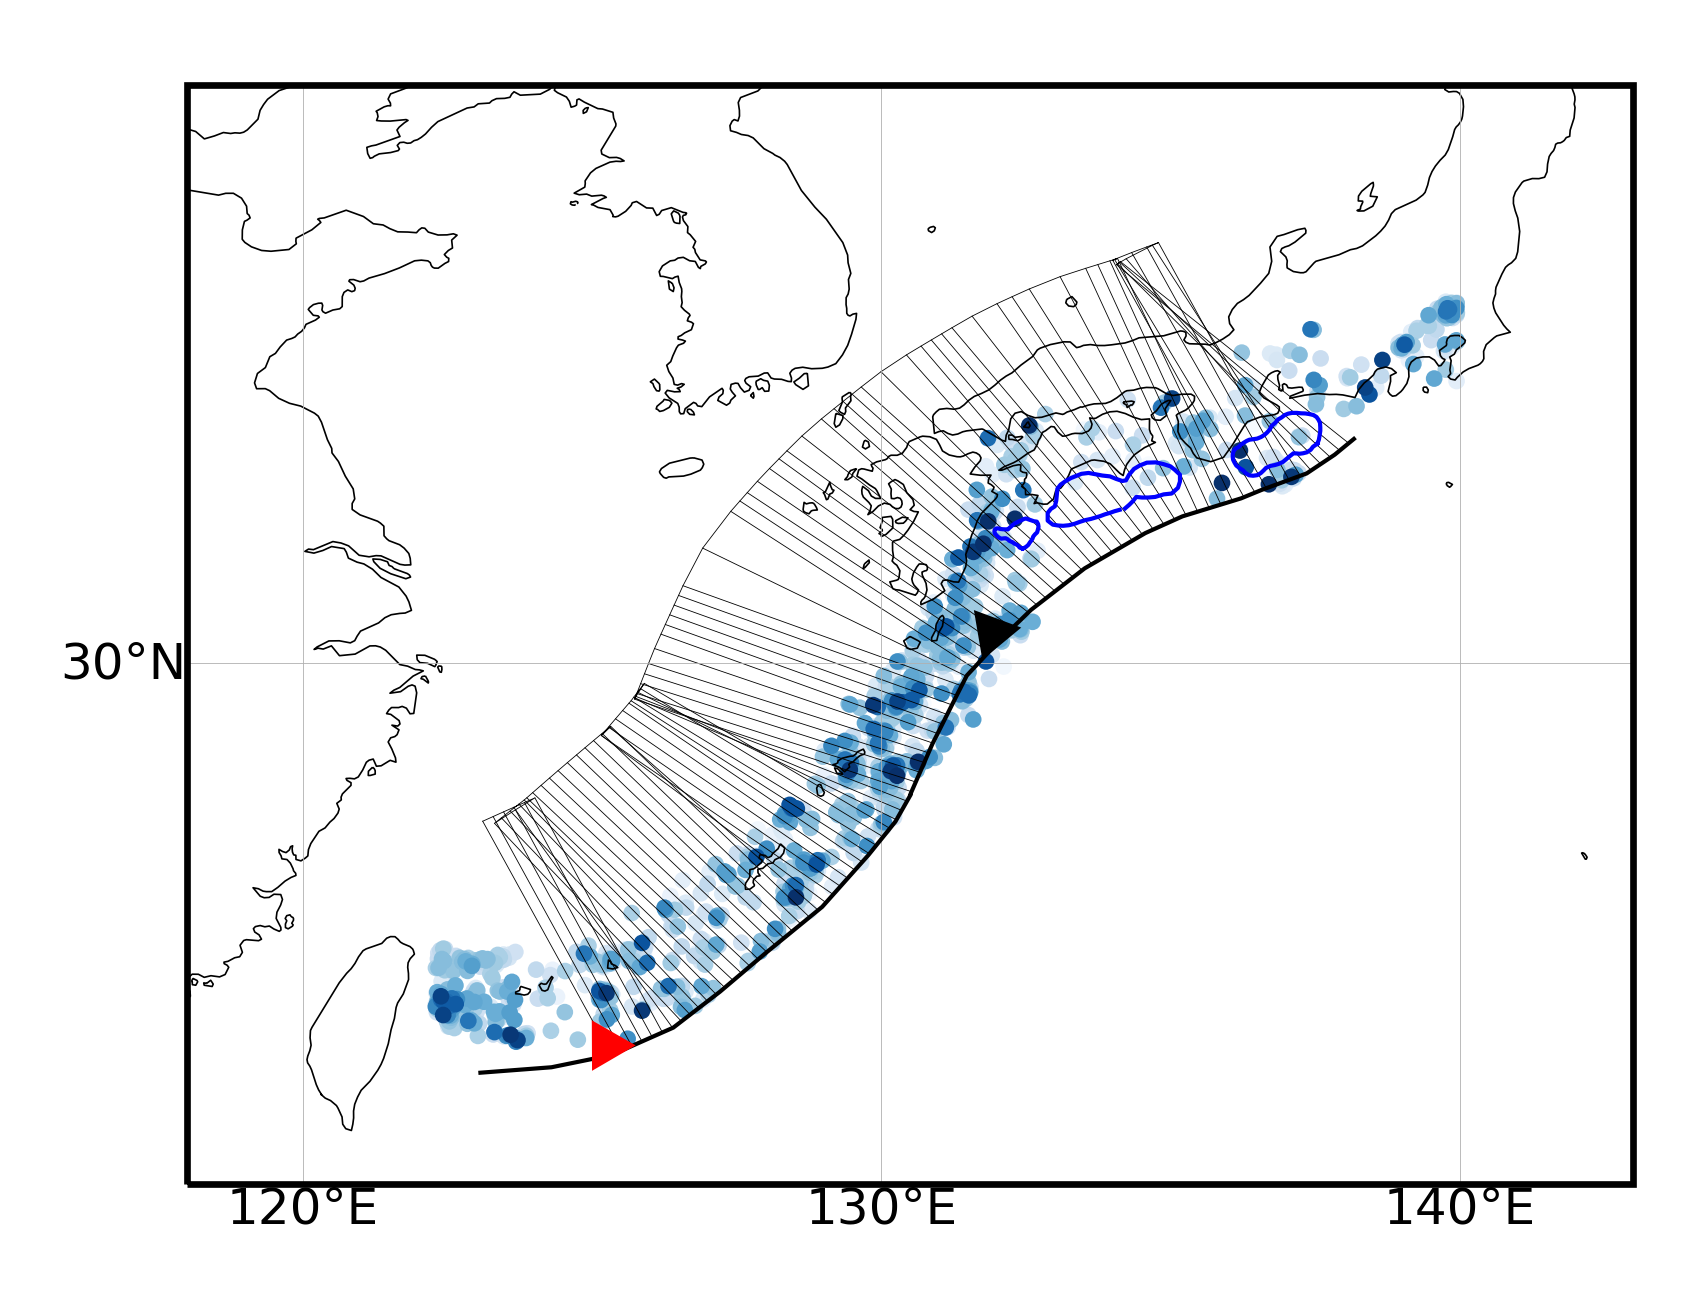

In [ ]:
with_grid = True
if make_map:

    # earthquake slip files
    fdir = root_dir/conf["slip_line"]

    eq_outlines = {}

    # iterate opening
    cnt = 0
    for subdir, dirs, files in os.walk(fdir):
        for file in files:
            
            fname = fdir/file
            print(fname)
            
            out_df = pd.read_csv(fname, sep = ',')
            
            print(fname)
            print(out_df.columns)
            if out_df.shape[1] > 2:
                out_df = out_df.sort_values(by = 'COUNT')
            #out_df.columns = ['LON', 'LAT']

            eq_outlines[cnt] = out_df
            cnt += 1

    outpath = outdir/region
    if with_grid:
        suffix = 'eq_grid.png'
    else:
        suffix = 'eq_raw.png'

    cmap = cmap_lut('EQ')
    vmin = 1
    vmax = 9
    tick_use = [1, 3, 5, 7, 9]
    tick_use = np.round(tick_use, 2)
    print(tick_use)

    eq_df2 = eq_df.sort_values(by = 'MW', ascending = True)

    mapper = vis_pkg.Mapper(dpi = dpi,
                    data = None,
                    topo = None,
                    extent = other_set["map_extent"],
                    dim_inch = other_set["map_wh_inch"],
                    is_alu = is_alu,
                    is_ker = is_ker
                    )
    mapper.create_basemap()
    mapper.add_trench_line(trench_df = trench_plt)
    mapper.add_trench_marker(trench_fname = root_dir/conf["trench_used"],
                            trench_arr_sz = trench_arr_sz
                            )

    mapper.add_slip_outlines(eq_outlines_dict = {'OUTLINE': eq_outlines, 
                                            'COLOR': "blue", 
                                            'AS_LINE':map_setting["eq_as_line"]})

    mapper.ax.scatter(  eq_df2["LON"], eq_df2["LAT"], marker = "o", 
                        c = eq_df2["MW"], s = 4, edgecolors = "none", cmap = "Blues",
                        vmin = 4, vmax = 7, transform=ccrs.PlateCarree())
    if with_grid:                                    
        add_sampling_grid(mapper.ax, lon_grid, lat_grid, color = 'k', linewidth=0.1, markersize=0.01, zorder = 1)

    # save the figure
    imgfile = outpath/suffix
    print(imgfile)
    mapper.fig.savefig(imgfile, bbox_inches='tight')
        

# Map of the gridded earthquake data

In [ ]:
#Save outputs - save one 
print(grid_feat_dict.shape)
if mode == 0:
    out_fname = root_dir/ml_conf['ml_temp0']
elif mode == 1:
    out_fname = root_dir/ml_conf['ml_temp1']

print("Saving to: ", out_fname)
#grid_feat_dict.to_csv(out_fname, sep = ',', index = False, header = True, float_format = '%.8f')

# if is_alu:
#     grid_feat_dict2.to_csv(conf['ml_feat2'], sep = ',', index = False, header = True)
    

(3945, 121)
Saving to:  /Users/jgra0019/Documents/codes/ml_proj1/ml_proj1/temp/mode0/sum_mthrust.csv


In [ ]:
if make_map:
    outpath = outdir/region
    suffix = 'eq_sampled.png'

    cmap = cmap_lut('EQ')
    vmin = 1
    vmax = round(grid_feat_dict['MW'].max())
    tick_use = vmin + np.array([0, 0.5, 1])*(vmax - vmin)
    tick_use = np.round(tick_use, 2)
    print(tick_use)

    idx = grid_feat_dict[grid_feat_dict['MW'].isna()].index
    grid_feat_dict['MW'].loc[idx] = 1

    fig, m = vis_pkg.make_heatmap(grid_feat_dict["LON_AVE"], grid_feat_dict["LAT_AVE"], grid_feat_dict["MW"], 
                                r'$M_w$_MAX', cmap, vmin, vmax, grid_feat_dict["MW"]**1.2, mrkr_edge='k', mrkr_lw = 0.3, is_alu = is_alu, 
                                is_ker = is_ker, norm = None, topo = None, extent = other_set["map_extent"], depth = None, 
                                trench_df = trench_plt, trench_fname = root_dir/conf["trench_used"], trench_arr_sz = trench_arr_sz,
                                eq_outlines_dict = None, label_dict = None, cbar_pos = other_set["cbar_ax"], 
                                cbar_ticks = tick_use, cbar_minor_ticks = None, dim_inch = other_set["map_wh_inch"], dpi = 300)

    add_sampling_grid(m, lon_grid, lat_grid, color = 'k', linewidth=0.1, markersize=0.01, zorder = 1)

    # save the figure
    imgfile = outpath/suffix
    print(imgfile)
    fig.savefig(imgfile, bbox_inches='tight')
        